In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv("./data/dragomanova10B.csv")

1. Проаналізувати завантажений датасет, провести підготовку для роботу із ним (форматування, видалення пустих значень тощо).

In [3]:
print(np.all(data['device_id'] == 17113))

True


In [4]:
data['value_text'].count()

0

In [5]:
data = data.drop(['value_text', 'device_id'], axis=1)

In [6]:
print(np.all(data == data.dropna()))

True


In [7]:
data

,phenomenon,value,logged_at
0,pm1,1.626000e+01,2021-03-28 00:00:21
1,pm25,2.712000e+01,2021-03-28 00:00:21
2,pm10,4.213000e+01,2021-03-28 00:00:21
3,pressure_pa,1.024480e+06,2021-03-28 00:00:21
4,humidity,6.526000e+01,2021-03-28 00:00:21
...,...,...,...
1158999,temperature,1.999000e+01,2024-09-27 10:30:13
1159000,no2_ug,4.377000e+01,2024-09-27 10:30:13
1159001,o3_ug,6.458000e+01,2024-09-27 10:30:13
1159002,no2_ppb,2.292230e+01,2024-09-27 10:30:13


In [8]:
data = pd.pivot_table(data, values='value', index='logged_at', columns='phenomenon')

In [9]:
data.isna().sum()

phenomenon
humidity       13
no2_ppb         2
no2_ug          2
o3_ppb          2
o3_ug           2
pm1             9
pm10           10
pm25            9
pressure_pa    13
temperature    14
dtype: int64

In [10]:
data.dropna(inplace=True)

In [11]:
data.isna().sum()

phenomenon
humidity       0
no2_ppb        0
no2_ug         0
o3_ppb         0
o3_ug          0
pm1            0
pm10           0
pm25           0
pressure_pa    0
temperature    0
dtype: int64

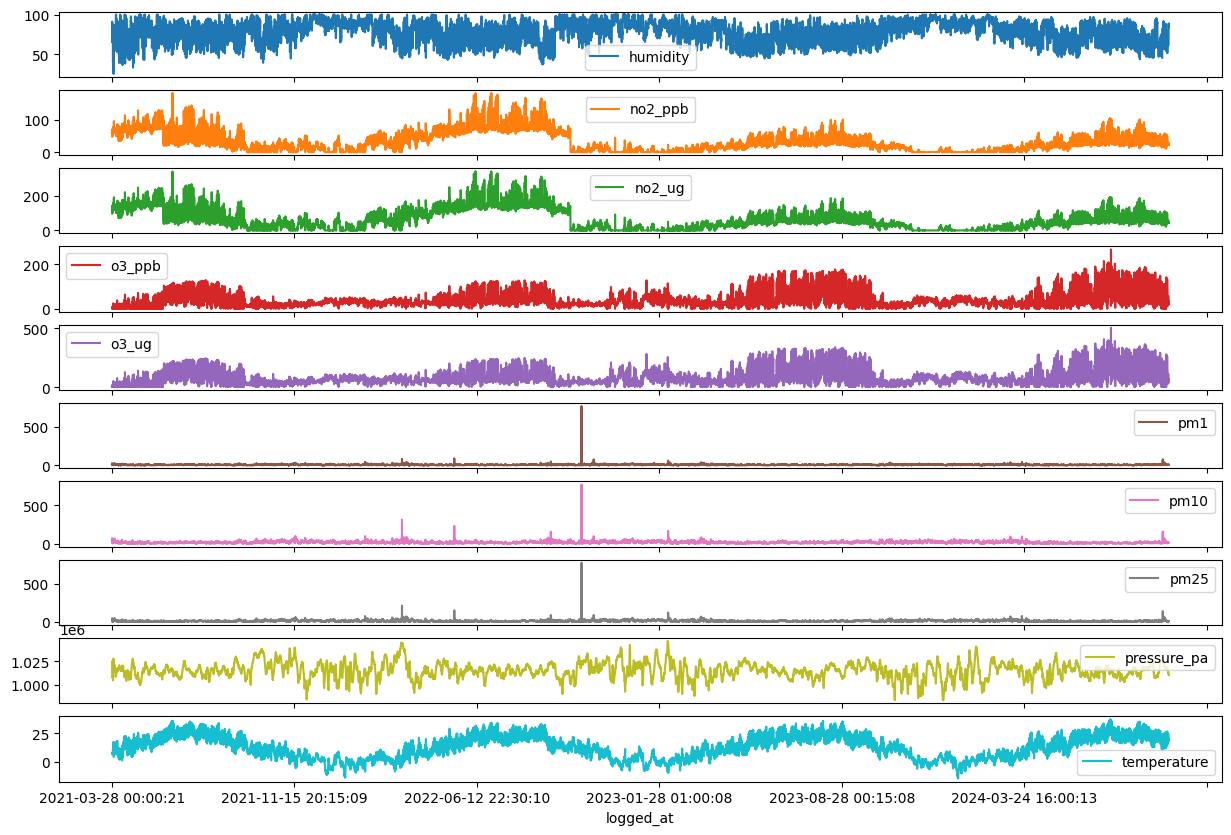

In [12]:
subplots = data.plot(subplots=True, figsize=(15, 10))

In [13]:
data.describe()

phenomenon,humidity,no2_ppb,no2_ug,o3_ppb,o3_ug,pm1,pm10,pm25,pressure_pa,temperature
count,115874.000000,115874.000000,115874.000000,115874.000000,115874.000000,115874.000000,115874.000000,115874.000000,1.158740e+05,115874.000000
mean,78.278399,30.274490,58.234875,38.395487,77.772939,8.024547,17.340635,13.058037,1.015146e+06,12.835221
std,13.364590,28.352018,53.746951,29.675183,57.428287,5.749945,12.885163,9.442928,8.354924e+03,9.981069
min,25.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.150000,0.080000,9.839800e+05,-14.500000
25%,68.765000,7.285575,14.632500,20.267600,41.890000,4.210000,7.910000,6.190000,1.010290e+06,4.360000
50%,80.560000,23.822600,46.330000,29.943100,62.150000,7.120000,14.060000,11.070000,1.015200e+06,12.890000
75%,88.810000,45.399900,87.170000,46.599350,96.890000,11.020000,24.230000,18.290000,1.020180e+06,20.870000
max,100.000000,184.435400,340.610000,265.804200,504.070000,771.740000,773.870000,773.480000,1.046080e+06,37.240000


In [14]:
data[data['pm1'] >= data['pm1'].quantile(0.9999)] = None
data[data['pm10'] >= data['pm10'].quantile(0.9999)] = None
data[data['pm25'] >= data['pm25'].quantile(0.9999)] = None

In [15]:
data.isna().sum()

phenomenon
humidity       36
no2_ppb        36
no2_ug         36
o3_ppb         36
o3_ug          36
pm1            36
pm10           36
pm25           36
pressure_pa    36
temperature    36
dtype: int64

In [16]:
data.dropna(inplace=True)
data.isna().sum()

phenomenon
humidity       0
no2_ppb        0
no2_ug         0
o3_ppb         0
o3_ug          0
pm1            0
pm10           0
pm25           0
pressure_pa    0
temperature    0
dtype: int64

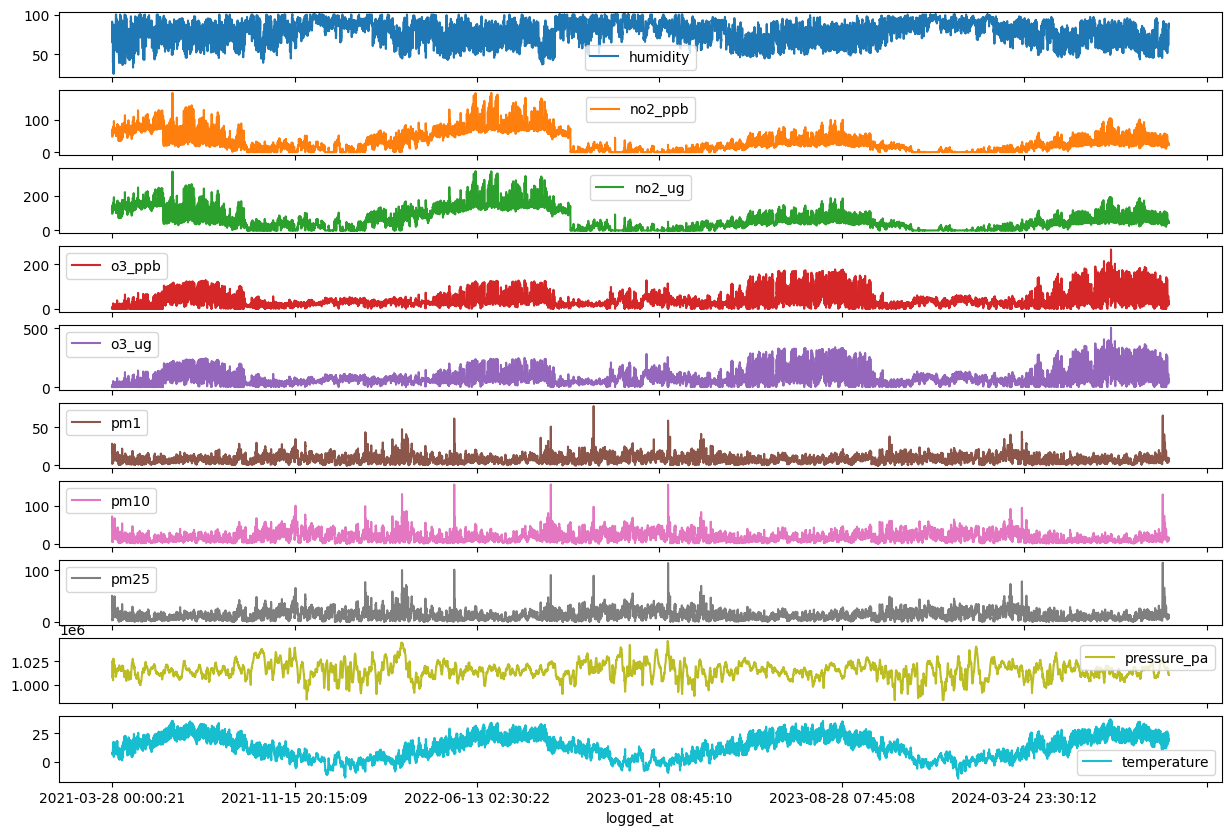

In [17]:
subplots = data.plot(subplots=True, figsize=(15, 10))

2. Знайти можливі залежності між забруднювачами повітря (чи залежить забруднювач PM2.5 від чадного газу і тд). Зробити це з використанням регресійного аналізу. Отримати показники залежностей (або показати, що такі залежності відсутні). 

<Axes: xlabel='phenomenon', ylabel='phenomenon'>

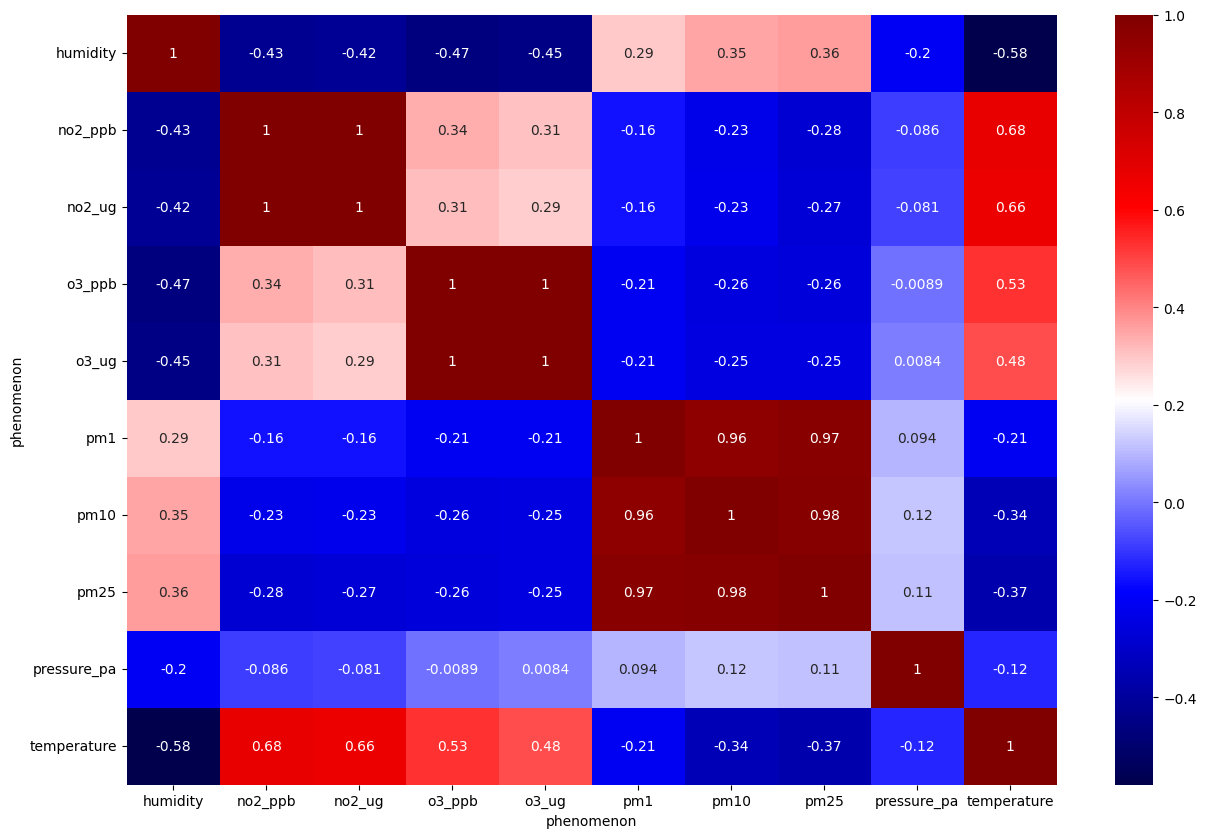

In [18]:
plt.figure(figsize=(15, 10))    
sns.heatmap(data=data.corr(method="pearson"), annot=True, cmap="seismic")

Дуже залежні: pm1, pm10 та pm25  
Залежні: NO2 та O3 від температури  
Мало залежні: NO2 та O3, а також pm1, pm10 та pm25 від вологості

3. Отримати регресійну модель залежності, використавши частину набору даних на навчання, іншу частину – на тестування моделі
    1. Залежність забрудника від часу дня (зранку повітря брудніше ніж вночі – це припущення. Обгрунтувати або спростувати його).
    2. Залежність одного забрудника від іншого

In [19]:
data.reset_index(inplace=True)

In [21]:
time_range_data = data[data['logged_at'].str.contains("2022")]
time_range_data['logged_at'] = pd.to_datetime(time_range_data['logged_at'])

C:\Users\dadmo\AppData\Local\Temp\ipykernel_22000\2520173362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_range_data['logged_at'] = pd.to_datetime(time_range_data['logged_at'])


In [22]:
time_range_data_months = []
for month in range(1, 13):
    time_range_data_months += [(month, time_range_data[time_range_data['logged_at'].dt.month == month])]

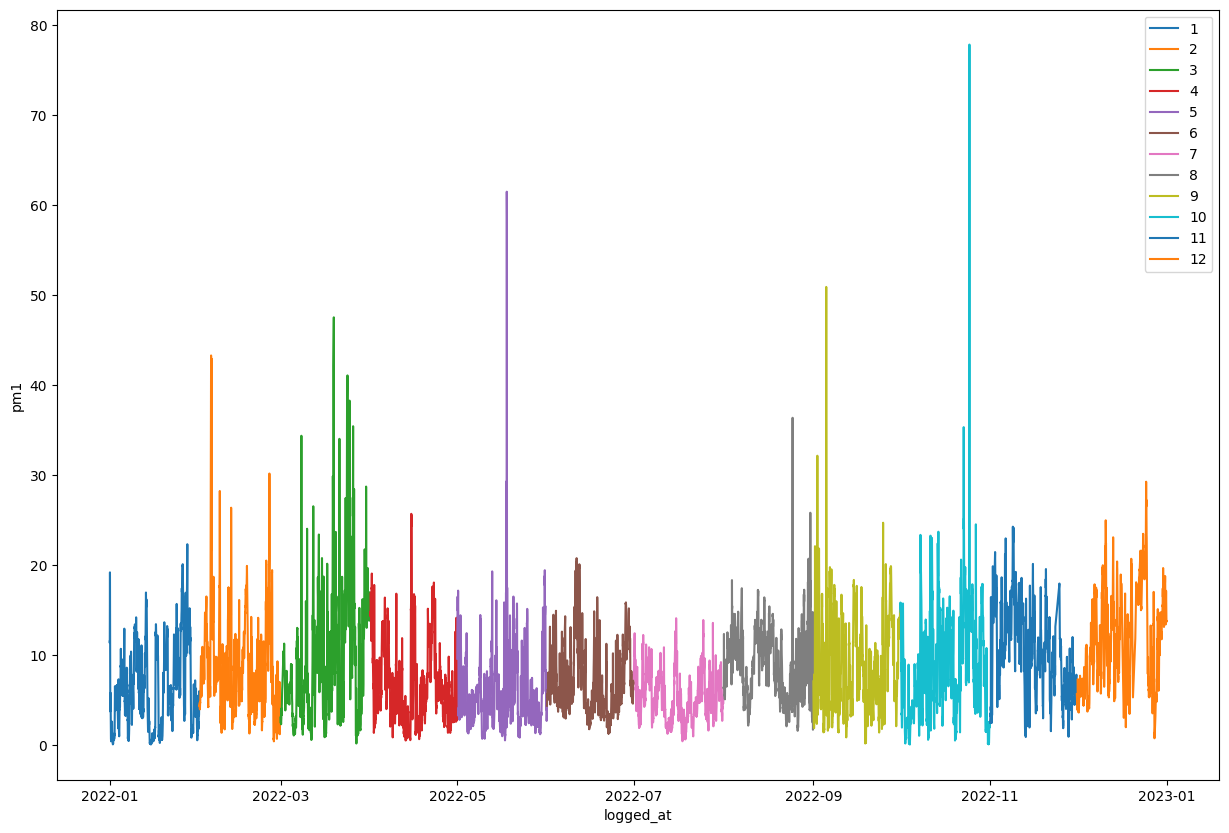

In [23]:
plt.figure(figsize=(15, 10))
for month, month_data in time_range_data_months:
    sns.lineplot(y='pm1', x='logged_at', data=month_data, label=month)

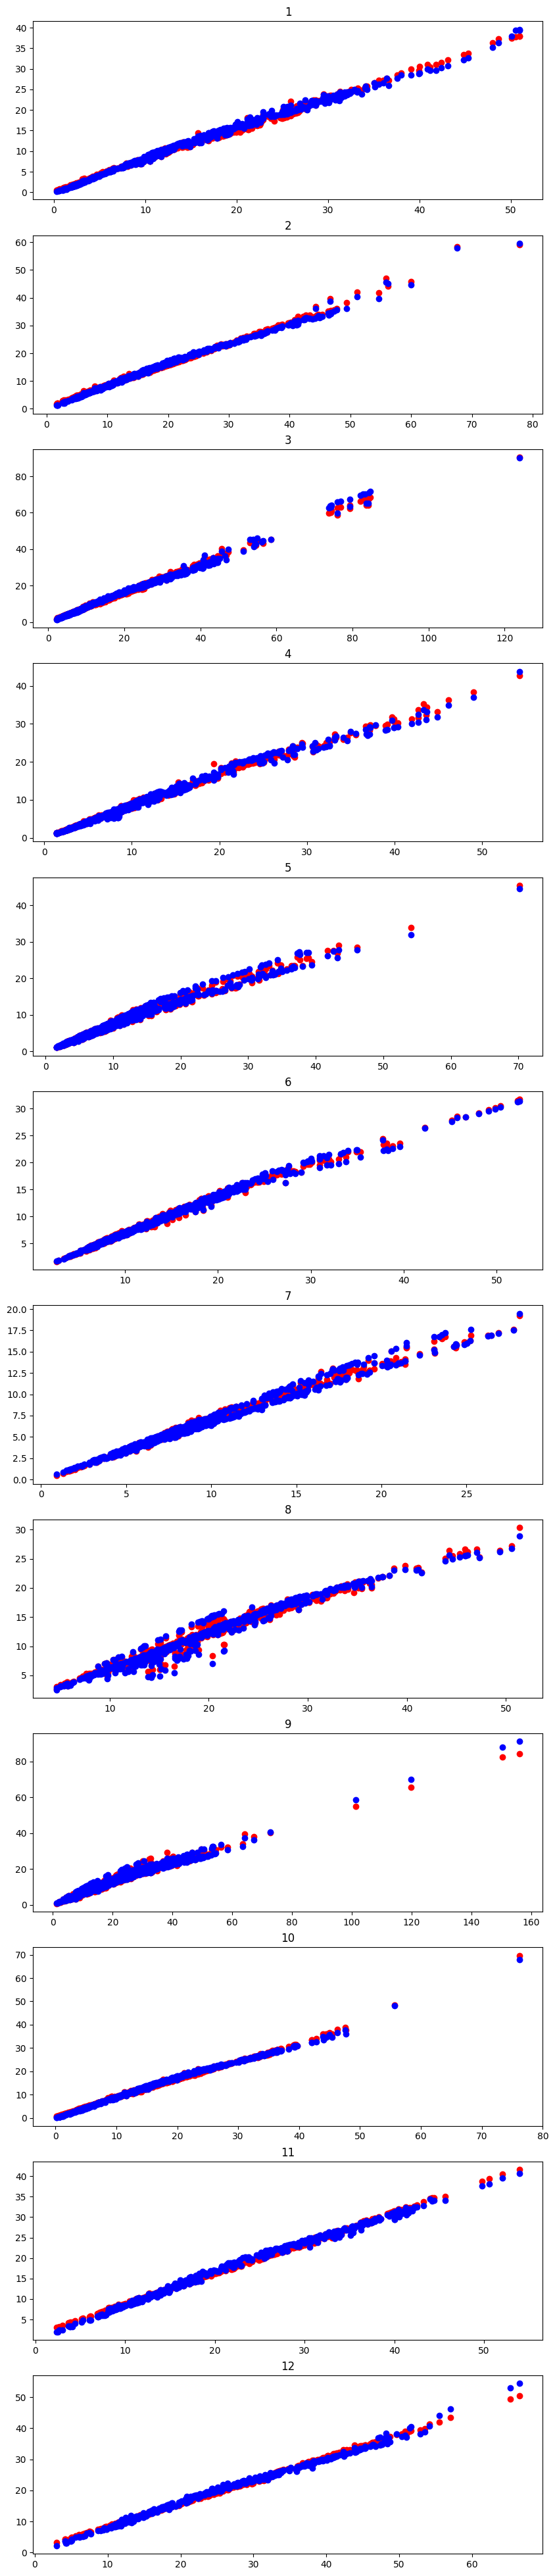

In [68]:
figure, ax = plt.subplots(12, 1, figsize=(10, 50), sharex=False, sharey=False)
for month, month_data in time_range_data_months:
    month_data = month_data.copy()
    month_data.reset_index(inplace=True)
    X = month_data[["pm1", "pm10"]]
    Y = month_data["pm25"]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    linear_reg = LinearRegression()
    linear_reg.fit(x_train, y_train)
    linear_reg_pred = linear_reg.predict(x_test)

    ax[month-1].scatter(x=x_test['pm10'], y=linear_reg_pred.reshape(linear_reg_pred.shape[0]), color='r')
    ax[month-1].scatter(x=x_test['pm10'], y=y_test, color='b')
    ax[month-1].set_title(month)

4. Отримати чисельні оцінки (RMSE, R^2) отриманої моделі.

In [69]:
rmse_linear = mean_squared_error(x_test['pm10'], linear_reg_pred)
r2 = r2_score(x_test['pm10'], linear_reg_pred)

print(f'RMSE: {rmse_linear}')
print(f'R2: {r2}')

RMSE: 45.39504127992153
R2: 0.6975537279987599


5. Описати отримані результати та виокремити отримані висновки та припущення.

RMSE: 127.12818649807208 for 1
R2: -5.586796322035167 for 1
RMSE: 896.5979556714832 for 2
R2: -70.66991957737473 for 2
RMSE: 961.8485383633981 for 3
R2: -35.678962271439374 for 3
RMSE: 1747.0815131647748 for 4
R2: -79.6221543517366 for 4
RMSE: 2690.658649067382 for 5
R2: -135.4587689286849 for 5
RMSE: 4419.132251532918 for 6
R2: -178.99354176517426 for 6
RMSE: 4053.007364691285 for 7
R2: -178.45782876269175 for 7
RMSE: 3769.7583709518244 for 8
R2: -245.91752334950235 for 8
RMSE: 1773.6315240314773 for 9
R2: -159.96024187087272 for 9
RMSE: 21.045515740922237 for 10
R2: -0.6037029895108883 for 10
RMSE: 3.1362853828670016 for 11
R2: 0.8167697752275919 for 11
RMSE: 5.457675910222501 for 12
R2: 0.526902378664364 for 12


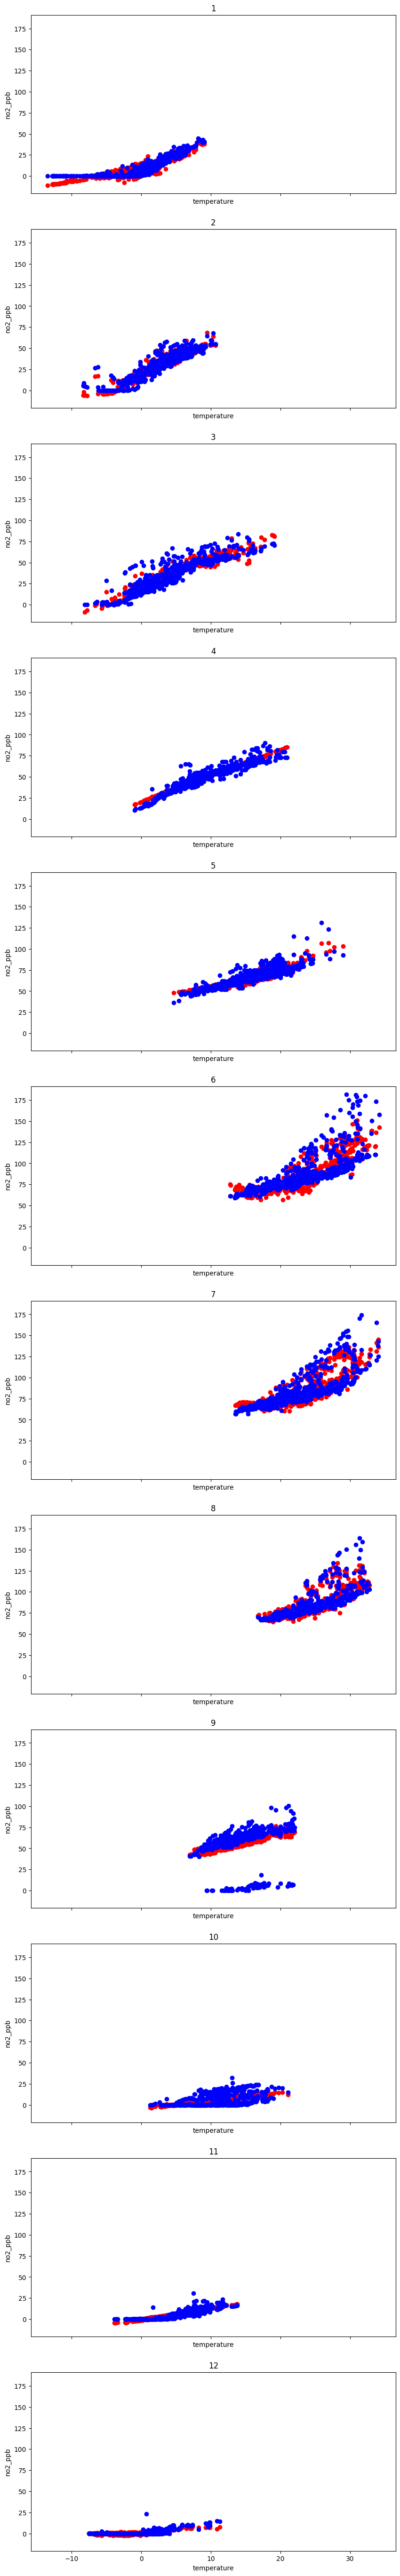

In [72]:
figure, ax = plt.subplots(12, 1, figsize=(10, 70), sharex=True, sharey=True)
for month, month_data in time_range_data_months:
    month_data = month_data.copy()
    month_data.reset_index(inplace=True)
    X = month_data[["o3_ppb", "o3_ug", "temperature"]]
    Y = month_data["no2_ppb"]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    linear_reg = LinearRegression()
    linear_reg.fit(x_train, y_train)
    linear_reg_pred = linear_reg.predict(x_test)

    ax[month-1].scatter(x=x_test['temperature'], y=linear_reg_pred.reshape(linear_reg_pred.shape[0]), color='r')
    ax[month-1].scatter(x=x_test['temperature'], y=y_test, color='b')
    ax[month-1].set_xlabel('temperature')
    ax[month-1].set_ylabel('no2_ppb')
    ax[month-1].set_title(month)

    rmse_linear = mean_squared_error(x_test['temperature'], linear_reg_pred)
    r2 = r2_score(x_test['temperature'], linear_reg_pred)

    print(f'RMSE: {rmse_linear} for {month}')
    print(f'R2: {r2} for {month}')

Отримали, що чим менше залежність між показниками тим більше буде розбіжність між очікуваною та справжньою. Також, як можна побачити з температурою, що чим ближче до літа, тим більш нестабільними є результати прогнозування NO2.